In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [33]:
sig = pd.read_csv('100.sig.csv')
ann = pd.read_csv('100.csv')

In [115]:
def plot(sample, delta = 392):
    plt.figure(figsize=(14,4))
    sig1 = sig['MLII'][sample - delta:sample + delta]
    sig2 = sig['V5'][sample - delta:sample + delta]
    sig1 -= sig1.mean()
    sig1 /= sig1.std()
    sig2 -= sig2.mean()
    sig2 /= sig2.std()
    print(np.fmin(sig1.min(), sig2.min()))
    plt.scatter(sample, np.fmin(sig1.min(), sig2.min()), c='red')
    sig1.plot()
    sig2.plot()

-1.79658565787


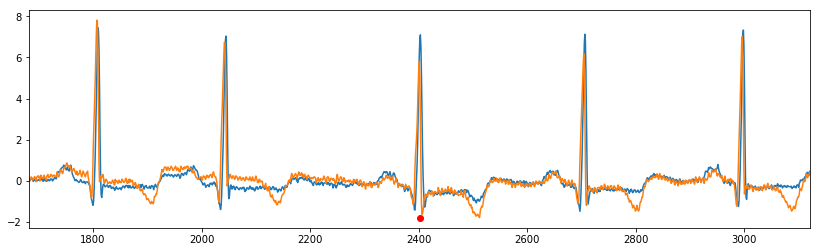

In [215]:
plot(2402, 720)

In [131]:
60/60 * 360 * 2

720.0

In [148]:
ann[ann['Type'] == 'N']

,Time,Sample #,Type,Sub,Chan,Num,Aux
1,0:00.214,77,N,0,0,0,NaN
2,0:01.028,370,N,0,0,0,NaN
3,0:01.839,662,N,0,0,0,NaN
4,0:02.628,946,N,0,0,0,NaN
5,0:03.419,1231,N,0,0,0,NaN
6,0:04.208,1515,N,0,0,0,NaN
7,0:05.025,1809,N,0,0,0,NaN
9,0:06.672,2402,N,0,0,0,NaN
10,0:07.517,2706,N,0,0,0,NaN
11,0:08.328,2998,N,0,0,0,NaN


### Autoencoder

In [198]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 128  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [194]:
x, delta = [], int(784 / 2)
for i in ann[ann['Type'] == 'N']['Sample #']:
    if i >= delta and i < len(sig) - delta:
        sample = np.array(sig['MLII'][i - delta:i + delta])
        x.append(sample.reshape(784,1))        

In [195]:
x_train = np.reshape(x, (len(x), 784))

In [209]:
autoencoder.fit(x_train, x_train,
                batch_size=128,
                nb_epoch=5,                
                shuffle=True
                )

Epoch 1/5
2235/2235 [==============================] - 0s - loss: -5095.3520     
Epoch 2/5
2235/2235 [==============================] - 0s - loss: -5095.3519     
Epoch 3/5
2235/2235 [==============================] - 0s - loss: -5095.3521     
Epoch 4/5
2235/2235 [==============================] - 0s - loss: -5095.3519     
Epoch 5/5
2235/2235 [==============================] - 0s - loss: -5095.3519     


In [211]:
encoded_imgs = encoder.predict(x_train)
decoded_imgs = decoder.predict(encoded_imgs)

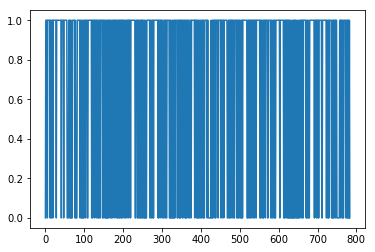

In [214]:
plt.plot(decoded_imgs[2])